In [9]:
%load_ext autoreload
%autoreload 2

import text3d2video.wandb_util as wu
from text3d2video.artifacts.vertex_atributes_artifact import VertAttributesArtifact

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
features_3d_artifact_tag = 'deadpool-3d-features:latest'

# get 3d features
features_3d = wu.get_artifact(features_3d_artifact_tag)
features_3d = VertAttributesArtifact.from_wandb_artifact(features_3d)

# get previous runs/artifacts from lineage
aggr_run = features_3d.logged_by()
mv_features = features_3d.get_mv_features_from_lineage()
animation = mv_features.get_animation_from_lineage()

# get vertex features
vert_features = features_3d.get_vert_features().cuda()

# extract feature config
feature_timestep = aggr_run.config['feature_timestep']
module_path = aggr_run.config['feature_layer']
feature_identifier = {'layer': module_path, 'timestep': feature_timestep}
feature_resolution = mv_features.get_resolution(feature_identifier)

print(f'Feature resolution: {feature_resolution}')
print(f'Feature timestep: {feature_timestep}')
print(f'Feature layer: {module_path}')

wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact deadpool-mv-features:v7, 592.93MB. 298 files... 
wandb:   298 of 298 files downloaded.  
Done. 0:0:1.1
wandb: Downloading large artifact backflip:v0, 121.09MB. 61 files... 
wandb:   61 of 61 files downloaded.  
Done. 0:0:0.4


Feature resolution: 64
Feature timestep: 20
Feature layer: up_blocks.3.attentions.2.transformer_blocks.0.attn1


/home/jorge/thesis/text3d2video/artifacts/vertex_atributes_artifact.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.folder / "features.pt")
/home

/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


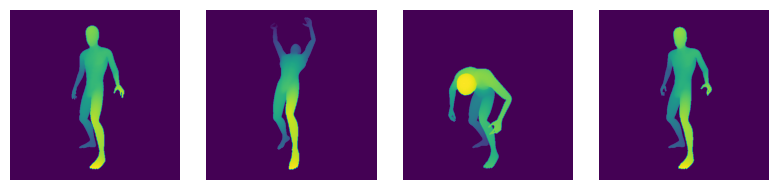

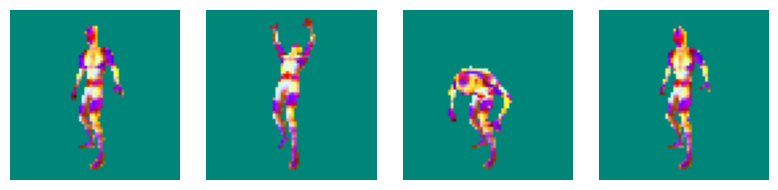

In [11]:
from einops import rearrange
from omegaconf import OmegaConf
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import make_rasterizer, normalize_depth_map, rasterize_vertex_features, render_depth_map
from text3d2video.util import front_camera, ordered_sample
from text3d2video.visualization import RgbPcaUtil
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF

cfg = OmegaConf.create({})
cfg.seed = 0
cfg.batch_size = 4
cfg.prompt = 'Deadpool'
cfg.frame_indices = ordered_sample(animation.frame_nums(), cfg.batch_size)
cfg.out_resolution = 512

# setup camera and frames
camera = front_camera()
frames = animation.load_frames(cfg.frame_indices)

# render depth maps
depth_maps = render_depth_map(frames, camera, cfg.out_resolution)

# display depth maps
display_ims(depth_maps, scale=2)

# rasterize vertex features
feature_images = torch.stack([
    rasterize_vertex_features(camera, frame, feature_resolution, vert_features)
    for frame in frames
])

# visualize rendered features
all_features = rearrange(feature_images, 'b c h w -> (b h w) c')
pca = RgbPcaUtil.init_and_fit(all_features.cpu())
pca_maps = [pca.feature_map_to_rgb_pil(map.cpu()) for map in feature_images]

display_ims(pca_maps, scale=2)

In [23]:
from diffusers import ControlNetModel
from text3d2video.cross_frame_attn import CrossFrameAttnProcessor
from text3d2video.pipelines.my_pipeline import  MyPipeline

dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/sd-controlnet-depth"
device = torch.device('cuda')

controlnet = ControlNetModel.from_pretrained(
    controlnet_repo,
    torch_dtype=torch.float16
).to(device)

pipe = MyPipeline.from_pretrained(
    sd_repo,
    controlnet=controlnet,
    torch_dtype=dtype
).to(device)


Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


100%|██████████| 31/31 [00:08<00:00,  3.86it/s]


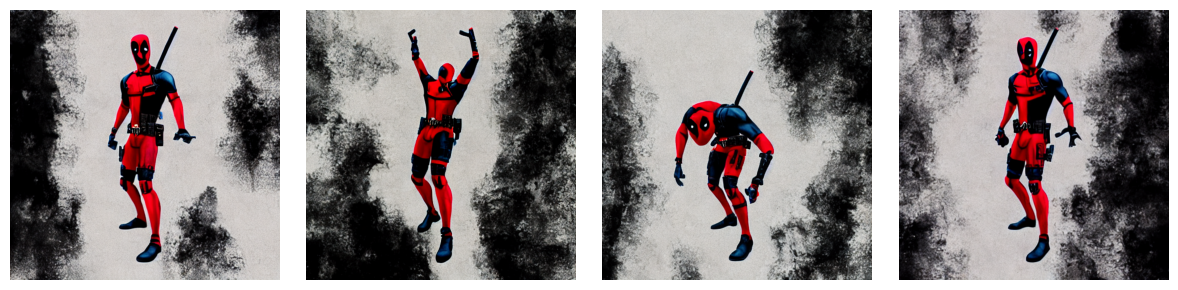

In [56]:
# run pipeline
prompt = 'Deadpool'

# cross-frame attention
attn_processor = CrossFrameAttnProcessor(unet_chunk_size=2, unet=pipe.unet)
pipe.unet.set_attn_processor(attn_processor)

prompts = [prompt] * cfg.batch_size

generator = torch.Generator(device='cuda')
generator.manual_seed(cfg.seed)

attn_processor.feature_images = feature_images
attn_processor.module_path = module_path

images = pipe(prompts, depth_maps, generator=generator, num_inference_steps=30)
display_ims(images, scale=3)